In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from typing import Optional, Callable

from scipy.stats import spearmanr, pearsonr


# Ensure project root on sys.path for local imports when running directly
try:
    HERE = os.path.dirname(os.path.abspath(__file__))  # type: ignore[name-defined]
except NameError:
    HERE = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(HERE, ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from cls import WMEnv
from cls.utils.GridUtils import VectorHash
from cls.envs.environments import GridWMEnv
from cls.vectorhash.seq_utils import *
from cls.vectorhash.assoc_utils_np import *
from cls.vectorhash.senstranspose_utils import *
from  cls.vectorhash.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d

seed = 3
rng = np.random.default_rng(seed)

In [3]:
def onehot2d_to_gaussian_np(x: np.ndarray,
                            sigma: float,
                            sigmay: float | None = None,
                            wrap: bool = True,
                            normalize: str = "none") -> np.ndarray:
    """
    Turn a one-hot 2D map into a wrapped 2D Gaussian bump.

    Args:
        x         : 2D array (H, W), assumed one-hot (but any single nonzero works).
        sigma     : std dev along x (columns), in pixels.
        sigmay    : std dev along y (rows); if None, uses sigma.
        wrap      : wrap distances horizontally and vertically (toroidal).
        normalize : "none" | "max" | "sum"

    Returns:
        2D float array (H, W)
    """
    x = x.astype(float, copy=False)
    H, W = x.shape
    if H == 0 or W == 0 or sigma <= 0:
        return np.zeros_like(x, dtype=float)

    pts = np.argwhere(x != 0)
    if pts.size == 0:
        return np.zeros_like(x, dtype=float)

    # If multiple nonzeros, we’ll just sum their bumps (still fine).
    sx = float(sigma)
    sy = float(sigmay if sigmay is not None else sigma)

    rows = np.arange(H)[:, None]               # (H,1)
    cols = np.arange(W)[None, :]               # (1,W)

    out = np.zeros((H, W), dtype=float)

    for (cy, cx) in pts:
        # Toroidal distances
        dy = np.abs(rows - cy)
        dx = np.abs(cols - cx)
        if wrap:
            dy = np.minimum(dy, H - dy)
            dx = np.minimum(dx, W - dx)

        g = np.exp(-0.5 * ((dy / sy) ** 2 + (dx / sx) ** 2))
        out += x[cy, cx] * g

    if normalize == "max":
        m = out.max()
        if m > 0: out /= m
    elif normalize == "sum":
        s = out.sum()
        if s > 0: out /= s

    return out


def smooth_g(g, lambdas, FWHM_ratio):
    gin = g.copy()
    gout = np.zeros_like(gin)
    i = 0
    for l in lambdas:
        #want FWHM to be a quarter of the lambda
        fwhm = l * FWHM_ratio
        sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
        two_d_gin = gin[i:i+l**2].reshape(l, l)
        gout[i:i+l**2] = onehot2d_to_gaussian_np(two_d_gin, sigma).flatten()
        i += l**2
    return gout

def smooth_gbook(gbook, lambdas, FWHM_ratio):
    smooth_gbook = np.zeros_like(gbook)
    for i in range(gbook.shape[1]):
        for j in range(gbook.shape[2]):
            smooth_gbook[:, i, j] = smooth_g(gbook[:, i, j], lambdas, FWHM_ratio)
    return smooth_gbook

def overlaps(self, x, y, px, py, size, touch_ok=True):
        if touch_ok:
            # touching edges allowed
            return not (x + size <= px or px + size <= x or y + size <= py or py + size <= y)
        else:
            # touching counts as overlap
            return not (x + size <  px or px + size <  x or y + size <  py or py + size <  y)

In [17]:
# -----------------------------
# Encoder: 1 hidden layer MLP + unit-sphere head
# -----------------------------
class SphericalMLP(nn.Module):
    def __init__(self, in_dim: int, hidden: int, out_dim: int, nonlinearity: str = "gelu", output_nonlinearity: str = "tanh"):
        super().__init__()
        act = {"relu": nn.ReLU, "gelu": nn.GELU, "tanh": nn.Tanh}.get(nonlinearity.lower(), nn.GELU)
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            act(),
            nn.Linear(hidden, out_dim),
        )
        self.output_nonlinearity = output_nonlinearity

    def forward(self, x: torch.Tensor, sigmoid_scale: float = 1) -> torch.Tensor:
        z = self.net(x)                         # [B, out_dim]
        if self.output_nonlinearity == "tanh":
            z = torch.tanh(sigmoid_scale * z)
        elif self.output_nonlinearity == "sigmoid":
            z = torch.sigmoid(sigmoid_scale * z)
        z = F.normalize(z, p=2, dim=-1)          # project to unit sphere
        return z

def _center_kernel(K: torch.Tensor) -> torch.Tensor:
    # Double-centering: Kc = K - row_mean - col_mean + grand_mean
    mean_row = K.mean(dim=1, keepdim=True)
    mean_col = K.mean(dim=0, keepdim=True)
    mean_all = K.mean()
    return K - mean_row - mean_col + mean_all
    
# -----------------------------
# Kernel alignment losses
#   - uncentered (classic alignment)
#   - centered (CKA-style), more robust in practice
# -----------------------------
def kernel_alignment_loss(K_pred: torch.Tensor, K_tgt: torch.Tensor, centered: bool = True, eps: float = 1e-8) -> torch.Tensor:
    """
    K_pred, K_tgt: [B, B] (same B). Returns 1 - alignment (minimize).
    """
    assert K_pred.ndim == 2 and K_tgt.ndim == 2, "kernels must be 2D"
    assert K_pred.shape == K_tgt.shape, "kernels must be same shape"

    if centered:
        Kp = _center_kernel(K_pred)
        Kt = _center_kernel(K_tgt)
    else:
        # mean subtraction makes it equivalent to Pearson-style correlation between matrices
        Kp = K_pred - K_pred.mean()
        Kt = K_tgt - K_tgt.mean()

    num = (Kp * Kt).sum()
    den = torch.sqrt(Kp.square().sum().clamp_min(eps)) * torch.sqrt(Kt.square().sum().clamp_min(eps))
    return 1.0 - num / den


def uniformity_loss(z: torch.Tensor, t: float = 2.0) -> torch.Tensor:
    """
    Uniformity regularizer on the sphere.
    z : [B, d] embeddings (they can be raw; we L2-normalize inside)
    t : temperature (larger => stronger repulsion)

    Loss = log( mean_{i!=j} exp( -t * ||zi - zj||^2 ) )
    Lower is more uniform (more spread out).
    """
    # L2-normalize so distances are angular
    z = torch.nn.functional.normalize(z, dim=-1)  # [B, d]
    B = z.size(0)
    if B < 2:
        return z.new_zeros(())

    # Pairwise squared distances using Gram matrix
    # ||zi - zj||^2 = 2 - 2 * <zi, zj> for unit vectors
    S = z @ z.t()                                  # [B, B]
    dist2 = (2.0 - 2.0 * S).clamp_min(0.0)

    # Exclude diagonal
    mask = ~torch.eye(B, dtype=torch.bool, device=z.device)
    dist2_off = dist2[mask]

    # Uniformity: log mean exp(-t * d^2)
    loss = torch.logsumexp(-t * dist2_off, dim=0) - torch.log(torch.tensor(dist2_off.numel(), device=z.device, dtype=z.dtype))
    return loss

def coplanarity_loss_sphere(z_triples: torch.Tensor) -> torch.Tensor:
    """
    z_triples: [T, 3, d], assumed (or made) unit-norm.
    Loss = mean det(Gram([u,v,w])) = mean parallelepiped volume^2.
    det(G)= 1 + 2abc - (a^2 + b^2 + c^2) for a=<u,v>, b=<u,w>, c=<v,w>.
    """
    z = F.normalize(z_triples, dim=-1)
    u, v, w = z[:, 0, :], z[:, 1, :], z[:, 2, :]
    a = (u * v).sum(-1)
    b = (u * w).sum(-1)
    c = (v * w).sum(-1)
    detG = 1.0 + 2.0 * a * b * c - (a * a + b * b + c * c)
    return detG.mean()

def build_grid_triples(H: int, W: int, stride: int = 1, include_diagonals: bool = False, both_directions: bool = True) -> torch.Tensor:
    """
    Returns LongTensor [T, 3] of flattened indices (y*W + x) for consecutive triples.
    - Rows: (x, x+stride, x+2*stride) for each y
    - Cols: (y, y+stride, y+2*stride) for each x
    - Optionally diagonals (down-right, down-left)
    - Optionally both directions (also reversed triples)
    """
    triples = []

    # rows
    for y in range(H):
        for x in range(0, W - 2 * stride):
            i0 = y * W + x
            i1 = y * W + (x + stride)
            i2 = y * W + (x + 2 * stride)
            triples.append((i0, i1, i2))
            if both_directions:
                triples.append((i2, i1, i0))

    # cols
    for x in range(W):
        for y in range(0, H - 2 * stride):
            i0 = y * W + x
            i1 = (y + stride) * W + x
            i2 = (y + 2 * stride) * W + x
            triples.append((i0, i1, i2))
            if both_directions:
                triples.append((i2, i1, i0))

    if include_diagonals:
        # down-right
        for y in range(0, H - 2 * stride):
            for x in range(0, W - 2 * stride):
                i0 = y * W + x
                i1 = (y + stride) * W + (x + stride)
                i2 = (y + 2 * stride) * W + (x + 2 * stride)
                triples.append((i0, i1, i2))
                if both_directions:
                    triples.append((i2, i1, i0))
        # down-left
        for y in range(0, H - 2 * stride):
            for x in range(2 * stride, W):
                i0 = y * W + x
                i1 = (y + stride) * W + (x - stride)
                i2 = (y + 2 * stride) * W + (x - 2 * stride)
                triples.append((i0, i1, i2))
                if both_directions:
                    triples.append((i2, i1, i0))

    return torch.tensor(triples, dtype=torch.long)  # [T, 3]

def plane_loss_from_triples(
    encoder,
    Phi: torch.Tensor,          # [N, code_dim]
    triples_all: torch.Tensor,  # [T_all, 3] (CPU okay)
    T_batch: int,
    sigmoid_scale: float = 1.0,
) -> torch.Tensor:
    """
    Samples T_batch triples, encodes only unique indices once, computes spherical coplanarity loss.
    """
    device = Phi.device
    T_all = triples_all.size(0)
    sel = torch.randint(0, T_all, (min(T_batch, T_all),), device=triples_all.device)
    triples = triples_all[sel].to(device)                          # [Tb, 3]

    flat = triples.reshape(-1)                                     # [3*Tb]
    uniq, inv = torch.unique(flat, return_inverse=True)            # uniq: [U], inv: [3*Tb]
    Zuniq = encoder(Phi.index_select(0, uniq), sigmoid_scale)      # [U, d]
    z_triples = Zuniq.index_select(0, inv).view(-1, 3, Zuniq.size(-1))  # [Tb, 3, d]

    return coplanarity_loss_sphere(z_triples)


def sample_random_patches(H: int, W: int,
                          num_patches: int = 16,
                          max_ph: int = 10, max_pw: int = 10,
                          min_ph: int = 4,  min_pw: int = 4,
                          device=None) -> list[torch.Tensor]:
    """
    Returns a list of 1D LongTensors; each is the flattened indices (y*W+x)
    of a random H×W patch. Patch sizes are uniform in [min,max] per axis.
    """
    device = device or torch.device("cpu")
    patches = []
    for _ in range(num_patches):
        ph = torch.randint(min_ph, max_ph + 1, (1,), device=device).item()
        pw = torch.randint(min_pw, max_pw + 1, (1,), device=device).item()
        ph = min(ph, H); pw = min(pw, W)
        y0 = torch.randint(0, max(1, H - ph + 1), (1,), device=device).item()
        x0 = torch.randint(0, max(1, W - pw + 1), (1,), device=device).item()

        rows = []
        for dy in range(ph):
            y = y0 + dy
            row = torch.arange(x0, x0 + pw, device=device, dtype=torch.long) + y * W
            rows.append(row)
        patches.append(torch.stack(rows, dim=0).reshape(-1))  # [ph*pw]
    return patches  # list of [Pi]

def rbf_from_coords_local(Xcoords: torch.Tensor, idx: torch.Tensor, tau: float | None = None):
    """
    Builds RBF kernel for a small set of indices with a LOCAL tau (median distance).
    Returns K:[B,B], tau_local:scalar
    """
    Xi = Xcoords.index_select(0, idx)                  # [B, 2]
    x2 = (Xi**2).sum(dim=1, keepdim=True)
    D2 = (x2 + x2.T - 2 * (Xi @ Xi.T)).clamp_min(0.0)
    if tau is None:
        tri = torch.triu(torch.ones_like(D2, dtype=torch.bool), diagonal=1)
        D = torch.sqrt(D2 + 1e-12)
        tau = torch.quantile(D[tri], 0.5).clamp_min(1e-6)
    K = torch.exp(- D2 / (2.0 * (tau**2)))
    return K, tau

def _weighted_local_mse(Kp: torch.Tensor, Kt: torch.Tensor, alpha: float = 2.0, topk: int | None = 8) -> torch.Tensor:
    """
    Weighted MSE between Kp (cosine mapped to [0,1]) and Kt (RBF in [0,1]),
    emphasizing near pairs via weights w_ij = Kt^alpha. Optionally restrict to topk per row.
    """
    B = Kp.size(0)
    eye = torch.eye(B, device=Kp.device, dtype=Kp.dtype)
    Kp01 = (Kp + 1.0) * 0.5
    Kp01 = Kp01 * (1.0 - eye)
    Kt    = Kt   * (1.0 - eye)

    W = (Kt.clamp(0, 1)) ** alpha
    if topk is not None and topk < B - 1:
        vals, idx = torch.topk(Kt, k=min(topk, B-1), dim=1)
        mask = torch.zeros_like(Kt, dtype=torch.bool)
        mask.scatter_(1, idx, True)
        mask = mask | mask.T  # symmetrize
        if mask.float().mean() < 0.02:  # fallback if too sparse
            mask = torch.ones_like(Kt, dtype=torch.bool); mask.fill_diagonal_(False)
        W = W * mask

    active = (W > 0).float().sum().clamp_min(1.0)
    W = W * (active / W.sum().clamp_min(1e-8))  # normalize to keep scale stable
    return ((W * (Kp01 - Kt))**2).sum() / active

def local_weighted_alignment_loss(
    encoder,
    Phi: torch.Tensor,          # [N, code_dim]
    Xcoords: torch.Tensor,      # [N, 2] (grid coords)
    H: int, W: int,
    num_patches: int = 16,
    max_ph: int = 10, max_pw: int = 10,
    min_ph: int = 4,  min_pw: int = 4,
    alpha: float = 2.0,
    topk: int | None = 8,
    sigmoid_scale: float = 1.0,
) -> torch.Tensor:
    """
    Samples multiple small patches across the grid (global coverage),
    encodes all unique points once, and averages weighted local MSE
    (with per-patch local τ) over patches.
    """
    device = Phi.device
    patches = sample_random_patches(H, W, num_patches, max_ph, max_pw, min_ph, min_pw, device=device)
    if len(patches) == 0:
        return Phi.new_zeros(())

    # Gather all unique indices once
    all_idx = torch.unique(torch.cat(patches, dim=0))
    Z_all = encoder(Phi.index_select(0, all_idx), sigmoid_scale)     # [U, d]
    Z_all = F.normalize(Z_all, dim=-1)

    # Map each patch to positions in Z_all for fast slicing
    # Build a lookup from original index -> position in all_idx
    # (torch.unique with return_inverse could also be used; we keep it simple)
    pos = {int(idx.item()): i for i, idx in enumerate(all_idx)}
    loss_sum = Phi.new_zeros(())
    count = 0.0

    for p in patches:
        if p.numel() < 4:
            continue
        # positions for this patch
        ids = torch.tensor([pos[int(ii.item())] for ii in p], device=device, dtype=torch.long)
        Zp = Z_all.index_select(0, ids)                                # [Bp, d]
        Kp = (Zp @ Zp.T).clamp(-1.0, 1.0)                              # [Bp, Bp]
        Kt, _tau_loc = rbf_from_coords_local(Xcoords, p)               # [Bp, Bp], local τ

        loss_sum = loss_sum + _weighted_local_mse(Kp, Kt, alpha=alpha, topk=topk)
        count += 1.0

    if count == 0.0:
        return Phi.new_zeros(())
    return loss_sum / count


    
@torch.no_grad()
def estimate_tau_median(X_coords: torch.Tensor, sample_pairs: int = 50000) -> float:
    """
    Estimate median pairwise distance from a random subset of pairs.
    X_coords: [N, 2] on CPU or GPU.
    """
    N = X_coords.size(0)
    device = X_coords.device
    i = torch.randint(0, N, (sample_pairs,), device=device)
    j = torch.randint(0, N, (sample_pairs,), device=device)
    mask = i != j
    i, j = i[mask], j[mask]
    d = torch.linalg.norm(X_coords[i] - X_coords[j], dim=-1)
    return float(d.median().item())

def rbf_kernel_from_coords_batch(X_coords: torch.Tensor, idx: torch.Tensor, tau: float) -> torch.Tensor:
    """
    Build RBF kernel K[idx, idx] on-the-fly.
    X_coords: [N, 2] (or [N, d_xy]), idx: [B], returns [B, B].
    """
    Xb = X_coords.index_select(0, idx)               # [B, 2]
    diff = Xb[:, None, :] - Xb[None, :, :]           # [B, B, 2]
    dist2 = (diff * diff).sum(-1)                    # [B, B]
    K = torch.exp(- dist2 / (2.0 * (tau ** 2)))
    return K

# -----------------------------
# Target kernel builders g(D)
# -----------------------------
def rbf_from_dist(D: torch.Tensor, tau: float) -> torch.Tensor:
    # K_ij = exp( - D_ij^2 / (2 tau^2) )
    return torch.exp(- (D**2) / (2.0 * (tau**2)))

def linear_from_dist(D: torch.Tensor, scale: float) -> torch.Tensor:
    # clamp into [0, 1] then rescale to similarities (1 close, 0 far)
    K = torch.clamp(1.0 - D / scale, min=0.0, max=1.0)
    return K

# -----------------------------
# Utilities: pairwise Euclidean distances
# -----------------------------
def pairwise_dist(xy: torch.Tensor) -> torch.Tensor:
    # xy: [N, d]
    # returns D: [N, N]
    x2 = (xy**2).sum(dim=1, keepdim=True)
    D2 = x2 + x2.T - 2.0 * (xy @ xy.T)
    D2 = torch.clamp(D2, min=0.0)
    return torch.sqrt(D2 + 1e-12)

# -----------------------------
# Dataset that just yields indices (we build kernels from batch slices)
# -----------------------------
class IndexDataset(Dataset):
    def __init__(self, N: int):
        self.N = N
    def __len__(self):
        return self.N
    def __getitem__(self, idx):
        return idx

# -----------------------------
# Training step
# -----------------------------
def train_epoch(encoder, Phi, Xcoords, tau, optimizer, batch_size, triples_all, T_triple_batch, centered=True, sigmoid_scale=1, uniformity_lambda=0, lambda_plane=0, lambda_local=0):
    device = next(encoder.parameters()).device
    ds = IndexDataset(Phi.size(0))
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

    encoder.train()
    running = 0.0

    for idx in dl:
        idx = idx.to(device).long()
        xb = Phi[idx]                          # [B, p]
        zb = encoder(xb, sigmoid_scale)                       # [B, k]; encoder already L2-normalizes
        assert zb.ndim == 2, f"zb ndim != 2, got {zb.shape}"

        # robust kernel
        K_pred = torch.einsum('ik,jk->ij', zb, zb).clamp(-1.0, 1.0)   # [B, B]
        # K_tgt  = Kt_full.index_select(0, idx).index_select(1, idx)    # [B, B]
        K_tgt  = rbf_kernel_from_coords_batch(Xcoords, idx, tau)

        # alignment loss (centered = CKA-like)
        loss = kernel_alignment_loss(K_pred, K_tgt, centered=centered)
        # loss += uniformity_lambda * uniformity_loss(zb)

        # after global loss pieces (CKA, uniformity, plane, etc.)
        with torch.no_grad():
            H = int(Xcoords[:,0].max().item() + 1)
            W = int(Xcoords[:,1].max().item() + 1)

        L_local = local_weighted_alignment_loss(
            encoder, Phi, Xcoords, H, W,
            num_patches=16,         # 8–32 is typical
            max_ph=10, max_pw=10,   # cap patch size to keep O(P^2) cheap
            min_ph=4,  min_pw=4,
            alpha=2.0, topk=8,
            sigmoid_scale=sigmoid_scale,
        )
        loss = loss + lambda_local * L_local

        # --- AUX curvature pass ---
        L_plane = plane_loss_from_triples(
            encoder,
            Phi,                # [N, code_dim], already on device
            triples_all,        # precomputed [T_all, 3] (CPU ok)
            T_batch=T_triple_batch,
            sigmoid_scale=sigmoid_scale,
        )
        # loss = loss + lambda_plane * L_plane
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        running += float(loss)
    return running / len(dl)

def upper_tri_vec(M: torch.Tensor) -> torch.Tensor:
    tri = torch.triu(torch.ones_like(M), diagonal=1).bool()
    return M[tri]

@torch.no_grad()
def eval_full(
    encoder,
    Phi,                # [N, p]
    # Kt_full,            # [N, N] target kernel (e.g., RBF of D)
    Xcoords,
    tau,
    subset: int = 2048,
    centered: bool = True,
    D_true: torch.Tensor | None = None,  # [N, N] optional true distances
    tau_for_rbf: float | None = None,    # optional, if you want to reconstruct RBF from D
    sigmoid_scale: float = 1.0,
):
    """
    Returns a dict of metrics on a random subset.
    If D_true is provided, computes distance-based R^2 and Shepard stats.
    Otherwise, computes kernel-based metrics only.
    """
    device = next(encoder.parameters()).device
    N = Phi.size(0)
    M = min(subset, N)
    idx = torch.randperm(N, device=device)[:M]

    Xb = Phi[idx]                       # [M, p]
    Z   = encoder(Xb, sigmoid_scale)                   # [M, k], unit sphere
    Kp  = (Z @ Z.T).clamp(-1, 1)        # predicted cosine kernel
    # Kt  = Kt_full[idx][:, idx]          # target kernel on this subset
    Kt = rbf_kernel_from_coords_batch(X_coords=Xcoords, idx=idx, tau=tau) 

    # ---- Kernel correlation metrics (shape-of-geometry)
    s_pred = upper_tri_vec(Kp).detach().cpu().numpy()
    s_tgt  = upper_tri_vec(Kt).detach().cpu().numpy()

    # Pearson / Spearman of similarities
    try:
        from scipy.stats import spearmanr, pearsonr
        sp, _ = spearmanr(s_pred, s_tgt)
        pe, _ = pearsonr(s_pred, s_tgt)
    except Exception:
        # fallback without SciPy (Pearson)
        import numpy as np
        s0 = (s_pred - s_pred.mean()) / (s_pred.std() + 1e-8)
        t0 = (s_tgt  - s_tgt.mean())  / (s_tgt.std()  + 1e-8)
        pe = float(np.mean(s0 * t0))
        sp = float("nan")

    # Centered kernel alignment loss re-using your function
    align_loss = kernel_alignment_loss(Kp, Kt, centered=centered).item()
    
    # after global loss pieces (CKA, uniformity, plane, etc.)
    lambda_local = 0.5  # tune 0.2–1.0
    with torch.no_grad():
        H = int(Xcoords[:,0].max().item() + 1)
        W = int(Xcoords[:,1].max().item() + 1)

    L_local = local_weighted_alignment_loss(
        encoder, Phi, Xcoords, H, W,
        num_patches=8,         # 8–32 is typical
        max_ph=6, max_pw=6,   # cap patch size to keep O(P^2) cheap
        min_ph=4,  min_pw=4,
        alpha=2.0,
        sigmoid_scale=sigmoid_scale,
    )
    local_loss = L_local.item()

    # ---- Triplet accuracy (kernel order)
    # sample triplets (i, a, b) and check that Kp[i,a] > Kp[i,b] whenever Kt[i,a] > Kt[i,b]
    T = min(200000, M * 200)  # ~200 triplets per anchor; cap to keep fast
    i  = torch.randint(0, M, (T,), device=device)
    a  = torch.randint(0, M, (T,), device=device)
    b  = torch.randint(0, M, (T,), device=device)
    # avoid degenerate a==b or equal targets by masking later
    tgt_cmp = (Kt[i, a] > Kt[i, b])
    pred_cmp = (Kp[i, a] > Kp[i, b])
    mask = (a != b) & (i != a) & (i != b) & (Kt[i, a] != Kt[i, b])
    triplet_acc = (pred_cmp[mask] == tgt_cmp[mask]).float().mean().item() if mask.any() else float("nan")

    # ---- Nearest-neighbor consistency (kernel argmax)
    # nearest neighbor in target (exclude self)
    Kt_masked = Kt - torch.eye(M, device=device) * 1e9
    Kp_masked = Kp - torch.eye(M, device=device) * 1e9
    nn_tgt = Kt_masked.argmax(dim=1)
    nn_pred = Kp_masked.argmax(dim=1)
    nn_acc = (nn_tgt == nn_pred).float().mean().item()

    out = {
        "align_loss": align_loss,
        "pearson_sim": float(pe),
        "spearman_sim": float(sp),
        "triplet_acc": float(triplet_acc),
        "nn_consistency": float(nn_acc),
        "local_loss": float(local_loss),
    }

    # ---- Distance-based diagnostics (optional, if D_true is available)
    if D_true is not None:
        Db = D_true[idx][:, idx]                  # [M, M]
        # Predicted "distance" on the sphere: 1 - cosine (in [0, 2])
        S_pred = 1.0 - Kp
        # Choose a monotone map of D_true to compare (linear or exp). Use exp if tau provided:
        if tau_for_rbf is not None:
            # Map distance to similarity, then to a distance-like quantity to compare fairly
            # e.g., S_tgt = 1 - exp(-D^2/(2 tau^2))  ∈ [0,1]
            S_tgt = 1.0 - torch.exp(-(Db**2) / (2.0 * (tau_for_rbf**2)))
        else:
            # Scale D_true into [0,1] by dividing by its 95th percentile (robust)
            with torch.no_grad():
                tri = upper_tri_vec(Db)
                scale = torch.quantile(tri, 0.95).clamp(min=1e-6)
            S_tgt = (Db / scale).clamp(0, 1)

        sp_d = upper_tri_vec(S_pred).detach()
        st_d = upper_tri_vec(S_tgt).detach()

        # R^2
        st_mean = st_d.mean()
        ss_res = ((sp_d - st_d)**2).sum()
        ss_tot = ((st_d - st_mean)**2).sum().clamp(min=1e-12)
        r2 = float(1.0 - (ss_res / ss_tot))

        # Shepard line fit (least squares y = a*x + b), report slope, intercept, RMSE
        A = torch.stack([st_d, torch.ones_like(st_d)], dim=1)         # [P, 2]
        sol = torch.linalg.lstsq(A, sp_d).solution
        a = float(sol[0].item()); b = float(sol[1].item())
        rmse = float(torch.sqrt(((sp_d - (a*st_d + b))**2).mean()).item())

        out.update({
            "R2_distproxy": r2,
            "shepard_slope": a,
            "shepard_intercept": b,
            "shepard_RMSE": rmse,
        })

    return out


In [18]:
# ---------- (A) build random row/col sequences of length L on the HxW grid ----------
def sample_sequences(H: int, W: int, L: int, stride: int = 1, num_per_axis: int = 128, device=None):
    """
    Returns indices for sequences along rows and cols:
      seqs: [S, L] LongTensor of flattened indices (y*W + x)
    """
    seqs = []

    # rows
    if W >= (L-1)*stride + 1:
        ys = torch.randint(0, H, (num_per_axis,), device=device)
        xs = torch.randint(0, W - (L-1)*stride, (num_per_axis,), device=device)
        for y, x0 in zip(ys.tolist(), xs.tolist()):
            seqs.append([y*W + (x0 + k*stride) for k in range(L)])

    # cols
    if H >= (L-1)*stride + 1:
        xs = torch.randint(0, W, (num_per_axis,), device=device)
        ys = torch.randint(0, H - (L-1)*stride, (num_per_axis,), device=device)
        for x, y0 in zip(xs.tolist(), ys.tolist()):
            seqs.append([(y0 + k*stride)*W + x for k in range(L)])

    if not seqs:
        return torch.empty(0, L, dtype=torch.long, device=device)
    return torch.tensor(seqs, dtype=torch.long, device=device)

# ---------- (B) geodesic curvature via determinant of Gram for sliding triples ----------
def det_gram_triple(u, v, w):
    # u,v,w: [d], unit-norm expected
    a = torch.dot(u, v)
    b = torch.dot(u, w)
    c = torch.dot(v, w)
    return 1.0 + 2.0*a*b*c - (a*a + b*b + c*c)  # = vol^2 >= 0

def mean_triple_det_along_sequence(Z_seq):
    """
    Z_seq: [L, d] unit vectors along a single trajectory
    returns mean det(Gram) over sliding triples (0,1,2), (1,2,3), ...
    """
    L = Z_seq.size(0)
    if L < 3:
        return torch.tensor(0.0, device=Z_seq.device)
    vals = []
    for k in range(L-2):
        vals.append(det_gram_triple(Z_seq[k], Z_seq[k+1], Z_seq[k+2]))
    return torch.stack(vals).mean()

# ---------- (C) plane deviation: distance from each point to span{start, end} ----------
def plane_deviation_stats(Z_seq):
    """
    Z_seq: [L, d], unit vectors on sphere.
    Returns mean and max squared residual from the great-circle plane spanned by endpoints.
    """
    u0 = F.normalize(Z_seq[0], dim=0)
    u1 = F.normalize(Z_seq[-1], dim=0)

    # Build orthonormal basis Q for the 2D subspace span{u0, u1}
    q1 = u0
    r = u1 - torch.dot(q1, u1) * q1
    if torch.linalg.norm(r) < 1e-8:  # endpoints almost parallel; pick any orthonormal complement
        # find a vector orthogonal to q1
        e = torch.zeros_like(q1); e[0] = 1.0
        if torch.allclose(e, q1, atol=1e-6):
            e = torch.roll(e, 1)  # avoid exact colinearity
        r = e - torch.dot(q1, e) * q1
    q2 = F.normalize(r, dim=0)
    Q = torch.stack([q1, q2], dim=1)       # [d, 2]

    # Projection onto plane: P = Q Q^T
    # Residual squared = ||z - P z||^2 = ||z||^2 - ||Q^T z||^2  (since Q columns orthonormal)
    ZT = Z_seq @ Q                          # [L, 2]
    res2 = 1.0 - (ZT**2).sum(dim=1).clamp_min(0.0)  # each z is unit norm
    return res2.mean(), res2.max()

# ---------- (D) angle progression linearity (R^2) + monotonicity ----------
def angle_progression_stats(Z_seq):
    """
    Angle from start vs step index should grow roughly linearly if path hugs a great circle.
    Returns (R2, monotonic_fraction).
    """
    L = Z_seq.size(0)
    u0 = Z_seq[0]
    dots = (Z_seq @ u0).clamp(-1.0, 1.0)
    theta = torch.arccos(dots)              # [L]
    k = torch.arange(L, device=Z_seq.device, dtype=Z_seq.dtype)
    # Fit theta ~ a*k + b (least squares)
    A = torch.stack([k, torch.ones_like(k)], dim=1)  # [L,2]
    sol = torch.linalg.lstsq(A, theta).solution      # [2]
    theta_hat = A @ sol
    ss_res = ((theta - theta_hat)**2).sum()
    ss_tot = ((theta - theta.mean())**2).sum().clamp_min(1e-12)
    R2 = 1.0 - (ss_res / ss_tot)
    # monotonicity (exclude step 0)
    mono = (theta[1:] > theta[:-1]).float().mean() if L > 1 else torch.tensor(1.0, device=Z_seq.device)
    return float(R2.item()), float(mono.item())

# ---------- (E) top-level evaluator ----------
@torch.no_grad()
def trajectory_straightness_metrics(
    encoder,
    Phi,                    # [N, code_dim]
    H: int, W: int,
    L_seq: int = 16,
    stride: int = 1,
    num_per_axis: int = 128,
    sigmoid_scale: float = 1.0,
):
    """
    Samples row/col sequences, encodes them once, and computes straightness metrics:
      - mean plane deviation^2
      - max plane deviation^2
      - mean geodesic curvature (det(Gram) over triples)
      - angle progression R^2 and monotonicity
    Returns dict of aggregated means over sequences.
    """
    device = Phi.device
    seqs = sample_sequences(H, W, L=L_seq, stride=stride, num_per_axis=num_per_axis, device=device)  # [S,L]
    if seqs.numel() == 0:
        return {"num_seqs": 0}

    # Encode unique indices once
    flat = seqs.reshape(-1)
    uniq, inv = torch.unique(flat, return_inverse=True)
    Zuniq = encoder(Phi.index_select(0, uniq), sigmoid_scale)      # [U, d]
    Zuniq = F.normalize(Zuniq, dim=-1)
    Z_all = Zuniq.index_select(0, inv).view(seqs.size(0), L_seq, -1)  # [S, L, d]

    plane_mean_list, plane_max_list, det_list, R2_list, mono_list = [], [], [], [], []

    for s in range(Z_all.size(0)):
        Z_seq = Z_all[s]  # [L, d]
        pm, pM = plane_deviation_stats(Z_seq)
        detm   = mean_triple_det_along_sequence(Z_seq)
        R2, mono = angle_progression_stats(Z_seq)
        plane_mean_list.append(pm.item())
        plane_max_list.append(pM.item())
        det_list.append(detm.item())
        R2_list.append(R2)
        mono_list.append(mono)

    return {
        "num_seqs": int(Z_all.size(0)),
        "plane_dev_mean": float(torch.tensor(plane_mean_list).mean().item()),
        "plane_dev_max_mean": float(torch.tensor(plane_max_list).mean().item()),
        "triple_det_mean": float(torch.tensor(det_list).mean().item()),
        "angle_R2_mean": float(torch.tensor(R2_list).mean().item()),
        "angle_monotonic_frac_mean": float(torch.tensor(mono_list).mean().item()),
    }


In [19]:
lambdas = [11,12]
Ng = np.sum(np.square(lambdas))
Npos = np.prod(lambdas)
gbook = gen_gbook_2d(lambdas, Ng, Npos)
Phi_np = smooth_gbook(gbook, lambdas, 0.25)
Phi = torch.tensor(Phi_np, dtype=torch.float32)

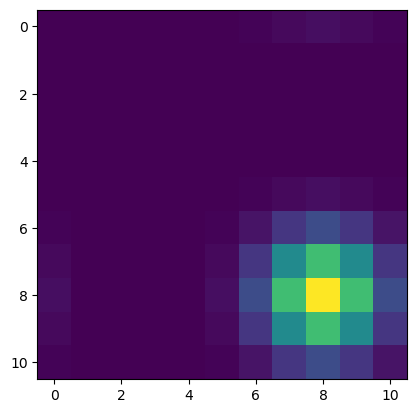

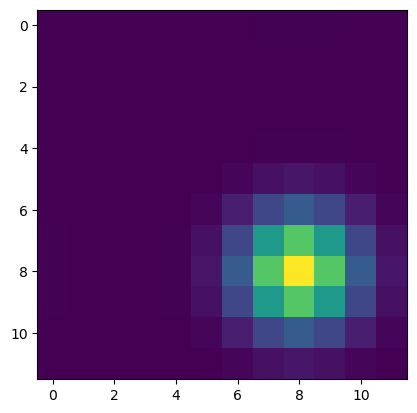

In [20]:
i = 0
for l in lambdas:
    plt.imshow(Phi_np[i:i+l**2, 8, 8].reshape(l, l))
    i += l**2
    plt.show()

Precomputed 66528 curvature triples.
Using device: cuda | N=17424 | code_dim=265 | embed_dim=512
RBF tau (median dist) = 67.6757
Epoch 01 | train_align_loss=0.8981 | align_loss=0.8580 | local_loss=0.015934 | Pearson(sim)=0.0581 | Spearman(sim)=0.0758 | TripletAcc=0.533 | NNconsistency=0.062
plane_dev_mean=0.125 | plane_dev_max_mean=0.421 | triple_det_mean=0.07250 | angle_R2_mean=0.117 | angle_monotonic_frac_mean=0.516
Epoch 02 | train_align_loss=0.5158 | align_loss=0.3059 | local_loss=0.018045 | Pearson(sim)=0.5920 | Spearman(sim)=0.6083 | TripletAcc=0.725 | NNconsistency=0.281
plane_dev_mean=0.120 | plane_dev_max_mean=0.288 | triple_det_mean=0.03851 | angle_R2_mean=0.550 | angle_monotonic_frac_mean=0.593
Epoch 03 | train_align_loss=0.2794 | align_loss=0.2736 | local_loss=0.024886 | Pearson(sim)=0.6339 | Spearman(sim)=0.6461 | TripletAcc=0.741 | NNconsistency=0.301
plane_dev_mean=0.139 | plane_dev_max_mean=0.365 | triple_det_mean=0.06278 | angle_R2_mean=0.581 | angle_monotonic_frac_mea

KeyboardInterrupt: 

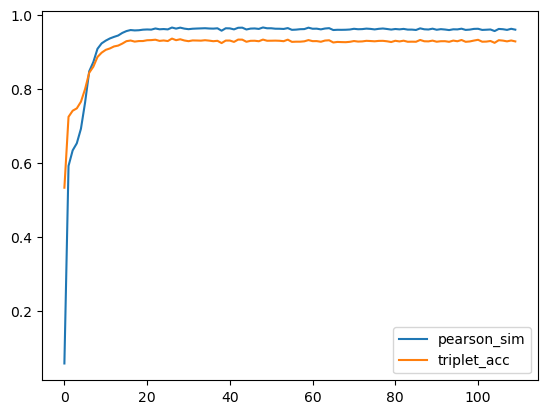

In [123]:
torch.manual_seed(0)

embed_dim = 512
hidden = 1024
batch_size = 256
lr = 1e-3
epochs = 500
centered = True  
output_nonlinearity = "tanh"
sigmoid_scale_start = 1
sigmoid_scale_end = 30
sigmoid_scale_up_epochs = 40
sigmoid_scales = np.logspace(np.log10(sigmoid_scale_start), np.log10(sigmoid_scale_end), sigmoid_scale_up_epochs)
sigmoid_scales = np.concatenate([sigmoid_scales, np.ones(epochs - sigmoid_scale_up_epochs) * sigmoid_scales[-1]])
# sigmoid_scales = np.linspace(sigmoid_scale_start, sigmoid_scale_end, epochs)

T_triple_batch = 4096     # 1k–10k is typical; scale with GPU mem
triple_stride = 3
include_diagonals = False
plane_lambda_start = 0
plane_lambda_end = 0
plane_lambda_scale_up_epochs = 30
plane_lambda_scales = np.linspace(plane_lambda_start, plane_lambda_end, plane_lambda_scale_up_epochs)
plane_lambda_scales = np.concatenate([plane_lambda_scales, np.ones(epochs - plane_lambda_scale_up_epochs) * plane_lambda_scales[-1]])

local_lambda_start = 0
local_lambda_end = 0
local_lambda_scale_up_epochs = 100
local_lambda_scales = np.linspace(local_lambda_start, local_lambda_end, local_lambda_scale_up_epochs)
local_lambda_scales = np.concatenate([local_lambda_scales, np.ones(epochs - local_lambda_scale_up_epochs) * local_lambda_scales[-1]])

uniformity_lambda_start = 0 #0.01
uniformity_lambda_end = 0 #5
uniformity_lambda_scales = np.linspace(uniformity_lambda_start, uniformity_lambda_end, epochs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Phi: [code_dim, H, W]  (original)
code_dim, H, W = Phi.shape
N = H*W

# reshape codes to [N, code_dim]
Phi_flat = Phi.reshape(code_dim, H*W).T.to(device)                 # [H*W, code_dim]

# build X coords
ys, xs = torch.meshgrid(
    torch.arange(H),
    torch.arange(W),
    indexing="ij"
)
X = torch.stack([ys, xs], dim=-1).reshape(-1, 2).float().to(device)    # [H*W, 2]
tau = estimate_tau_median(X, sample_pairs=50000)

triples_all = build_grid_triples(H, W, stride=triple_stride, include_diagonals=include_diagonals, both_directions=True)
print(f"Precomputed {triples_all.size(0)} curvature triples.")

# D = pairwise_dist(X)

# Phi_flat = Phi_flat.to(device)
# D = D.to(device)

# # target kernel: RBF of distances; set tau to median distance for decent dynamic range
# with torch.no_grad():
#     tri = torch.triu(torch.ones_like(D), diagonal=1).bool()
#     med = D[tri].median().item()
# tau = med
# Kt = rbf_from_dist(D, tau=tau)             # [N, N]
# # -----------------------------------------------

encoder = SphericalMLP(in_dim=Phi_flat.size(1), hidden=hidden, out_dim=embed_dim, nonlinearity="gelu", output_nonlinearity=output_nonlinearity).to(device)
optim = torch.optim.AdamW(encoder.parameters(), lr=lr, weight_decay=1e-4)

print(f"Using device: {device} | N={N} | code_dim={Phi_flat.size(1)} | embed_dim={embed_dim}")
print(f"RBF tau (median dist) = {tau:.4f}")

sims = []
triplet_accs = []

for ep in range(1, epochs + 1):
    sigmoid_scale = sigmoid_scales[ep - 1]
    tr_loss = train_epoch(
        encoder,
        Phi_flat,
        X,
        tau,
        optim,
        batch_size,
        triples_all,
        T_triple_batch,
        centered=centered,
        sigmoid_scale=sigmoid_scale,
        uniformity_lambda=uniformity_lambda_scales[ep - 1],
        lambda_plane=plane_lambda_scales[ep - 1],
        lambda_local=local_lambda_scales[ep - 1],
    )
    # metrics = evaluate(encoder, Phi_flat, Kt, subset=min(2048, N), centered=centered)
    # print(f"Epoch {ep:02d} | train_align_loss={tr_loss:.4f} | "
    #         f"val_align_loss={metrics['align_loss']:.4f} | "
    #         f"Spearman={metrics['spearman']:.4f} | Pearson={metrics['pearson']:.4f}")

    metrics = eval_full(
        encoder,
        Phi_flat,
        # Kt_full=Kt,
        Xcoords=X,
        tau=tau,
        subset=min(2048, N),
        centered=True,         # same as training
        D_true=None,              # OPTIONAL: pass if you have it
        tau_for_rbf=tau        # OPTIONAL: pass if Kt was built as RBF(D, tau)
    )

    print(
        f"Epoch {ep:02d} | train_align_loss={tr_loss:.4f} | "
        f"align_loss={metrics['align_loss']:.4f} | "
        f"local_loss={metrics['local_loss']:.6f} | "
        f"Pearson(sim)={metrics['pearson_sim']:.4f} | "
        f"Spearman(sim)={metrics['spearman_sim']:.4f} | "
        f"TripletAcc={metrics['triplet_acc']:.3f} | "
        f"NNconsistency={metrics['nn_consistency']:.3f}"
        + (f" | R2={metrics['R2_distproxy']:.3f} | RMSE={metrics['shepard_RMSE']:.3f}" if 'R2_distproxy' in metrics else "")
    )

    sims.append(metrics['pearson_sim'])
    triplet_accs.append(metrics['triplet_acc'])

    metrics_traj = trajectory_straightness_metrics(
        encoder,
        Phi_flat,            # [N, code_dim] on same device
        H=H, W=W,
        L_seq=16,            # try 8, 16, 32
        stride=triple_stride,
        num_per_axis=256,    # more sequences → tighter estimates
        sigmoid_scale=sigmoid_scale,
    )
    print(
        f"plane_dev_mean={metrics_traj['plane_dev_mean']:.3f} | "
        f"plane_dev_max_mean={metrics_traj['plane_dev_max_mean']:.3f} | "
        f"triple_det_mean={metrics_traj['triple_det_mean']:.5f} | "
        f"angle_R2_mean={metrics_traj['angle_R2_mean']:.3f} | "
        f"angle_monotonic_frac_mean={metrics_traj['angle_monotonic_frac_mean']:.3f}"
    )

    if ep % 10 == 0:
        plt.clf()  # Clear the current figure
        plt.plot(sims, label='pearson_sim')
        plt.plot(triplet_accs, label='triplet_acc')
        plt.legend()
        plt.draw()
        plt.pause(0.001)
        plt.show()

plt.plot(sims, label='pearson_sim')
plt.plot(triplet_accs, label='triplet_acc')
plt.legend()
plt.show()

In [ ]:
lrs = [1e-3, 1e-4]
batch_sizes = [256, 512, 1024]
hidden_sizes = [512, 1024, 2048]
embed_dims = [256, 512, 1024]
sigmoid_scales = [1, 30, 100]

#make a grid of all combinations
configs = list(itertools.product(lrs, batch_sizes, hidden_sizes, embed_dims, sigmoid_scales))

In [127]:
configs

[(0.001, 256, 512, 256, 1),
 (0.001, 256, 512, 256, 30),
 (0.001, 256, 512, 256, 100),
 (0.001, 256, 512, 512, 1),
 (0.001, 256, 512, 512, 30),
 (0.001, 256, 512, 512, 100),
 (0.001, 256, 512, 1024, 1),
 (0.001, 256, 512, 1024, 30),
 (0.001, 256, 512, 1024, 100),
 (0.001, 256, 1024, 256, 1),
 (0.001, 256, 1024, 256, 30),
 (0.001, 256, 1024, 256, 100),
 (0.001, 256, 1024, 512, 1),
 (0.001, 256, 1024, 512, 30),
 (0.001, 256, 1024, 512, 100),
 (0.001, 256, 1024, 1024, 1),
 (0.001, 256, 1024, 1024, 30),
 (0.001, 256, 1024, 1024, 100),
 (0.001, 256, 2048, 256, 1),
 (0.001, 256, 2048, 256, 30),
 (0.001, 256, 2048, 256, 100),
 (0.001, 256, 2048, 512, 1),
 (0.001, 256, 2048, 512, 30),
 (0.001, 256, 2048, 512, 100),
 (0.001, 256, 2048, 1024, 1),
 (0.001, 256, 2048, 1024, 30),
 (0.001, 256, 2048, 1024, 100),
 (0.001, 512, 512, 256, 1),
 (0.001, 512, 512, 256, 30),
 (0.001, 512, 512, 256, 100),
 (0.001, 512, 512, 512, 1),
 (0.001, 512, 512, 512, 30),
 (0.001, 512, 512, 512, 100),
 (0.001, 512, 51

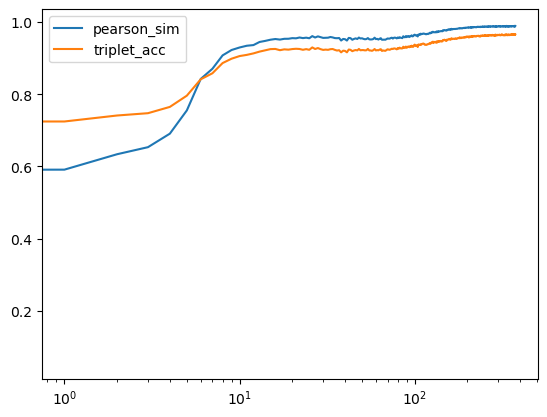

In [85]:
plt.plot(sims, label='pearson_sim')
plt.plot(triplet_accs, label='triplet_acc')
plt.legend()
plt.xscale('log')
plt.show()

In [86]:
X.shape

torch.Size([17424, 2])

In [87]:
encoded_Phi = encoder(Phi_flat, sigmoid_scale=sigmoid_scales[-1]).detach()
# encoded_Phi = encoded_Phi.reshape(embed_dim, H, H)

(array([259.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 252.]),
 array([-0.04421382, -0.03537106, -0.0265283 , -0.01768553, -0.00884277,
         0.        ,  0.00884276,  0.01768553,  0.02652829,  0.03537106,
         0.04421382]),
 <BarContainer object of 10 artists>)

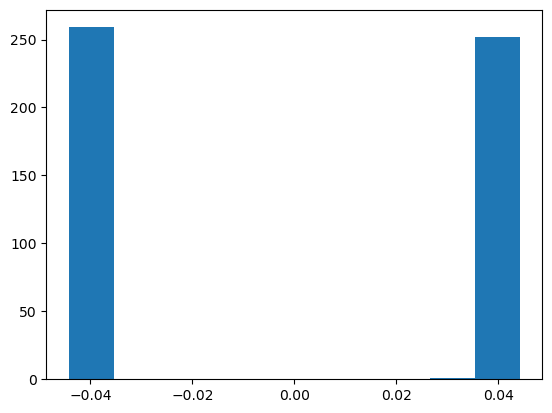

In [88]:
plt.hist(encoded_Phi[0].detach().cpu().numpy())

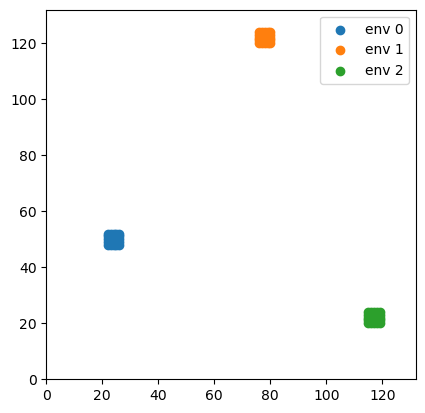

In [74]:
n_envs = 3
size = 5

used = []  # store placed (x, y)
C_pairs = []
max_tries = 10_000  # guard against infinite loops
touch_ok = False      # set False to forbid touching
tries = 0
while len(C_pairs) < n_envs and tries < max_tries:
    x = np.random.randint(0, Npos - size + 1)
    y = np.random.randint(0, Npos - size + 1)
    if all(not overlaps(x, y, px, py, size, touch_ok) for (px, py) in used):
        used.append((x, y))
        C_pairs.append((x, y))
    tries += 1

all_env_indices = []
goal_states = []
goal_locations = []

for env_idx in range(n_envs):
    C_X, C_Y = C_pairs[env_idx]
    x, y = np.meshgrid(np.arange(size), np.arange(size), indexing='ij')
    env_indices = np.stack((C_X + x, C_Y + y), axis=-1)
    all_env_indices.append(env_indices)

    flat_env = env_indices.reshape(-1, 2)
    goal_loc = flat_env[np.random.choice(len(flat_env))]
    goal_states.append(Phi[:, goal_loc[0], goal_loc[1]])
    goal_locations.append(goal_loc)

width, height = Npos, Npos

for env_idx in range(n_envs):
    env_indices = all_env_indices[env_idx]
    pos = env_indices.reshape(-1, 2)
    plt.scatter(pos[:, 0], pos[:, 1], label=f"env {env_idx}")

plt.xlim(0, width)
plt.ylim(0, height)
plt.gca().set_aspect('equal', adjustable='box')  # keep the aspect ratio square
plt.legend()
plt.show()

In [75]:
import torch
import torch.nn.functional as F
from typing import Optional, Tuple

class HopfieldEncoderRetriever(torch.nn.Module):
    """
    Hopfield-style retrieval on top of a learned unit-sphere encoder F.
    Now supports sequential adds via .add(...).
    """
    def __init__(self, encoder: torch.nn.Module):
        super().__init__()
        self.encoder = encoder
        self.register_buffer("Z_mem", None)   # [N, d] unit embeddings
        self.register_buffer("V_mem", None)   # [N, P] values
        self.N = 0
        self.embed_dim = None
        self.value_dim = None

    @torch.no_grad()
    def index(self,
              Phi_mem: torch.Tensor,                # [N, code_dim]
              values: Optional[torch.Tensor] = None,# [N, P] (defaults to Phi_mem)
              batch_size: int = 4096) -> None:
        """Build memory bank from scratch."""
        device = next(self.encoder.parameters()).device
        Phi_mem = Phi_mem.to(device)
        V_mem = Phi_mem if values is None else values.to(device)

        Z_mem = self.encoder(Phi_mem, sigmoid_scale=sigmoid_scales[-1])
        assert Z_mem.size(0) == V_mem.size(0), "values must align with memories"

        self.Z_mem = Z_mem
        self.V_mem = V_mem
        self.N = Z_mem.size(0)
        self.embed_dim = Z_mem.size(1)
        self.value_dim = V_mem.size(1) if V_mem.ndim == 2 else 1

    @torch.no_grad()
    def add(self,
            Phi_new: torch.Tensor,                 # [M, code_dim]
            values_new: Optional[torch.Tensor] = None,  # [M, P] (defaults to Phi_new)
            batch_size: int = 4096) -> None:
        """Append new memories (sequential storage)."""
        assert self.Z_mem is not None, "Call .index(...) before .add(...)"
        device = self.Z_mem.device
        Phi_new = Phi_new.to(device)
        V_new = Phi_new if values_new is None else values_new.to(device)

        Z_new = self.encoder(Phi_new, sigmoid_scale=sigmoid_scales[-1])
        assert Z_new.size(0) == V_new.size(0), "values must align with new memories"
        assert Z_new.size(1) == self.embed_dim, "embed dim mismatch with existing bank"
        if V_new.ndim == 1:
            V_new = V_new.unsqueeze(1)
        if self.V_mem.ndim == 1:
            self.V_mem = self.V_mem.unsqueeze(1)
        assert V_new.size(1) == self.V_mem.size(1), "value dim mismatch with existing bank"

        # append
        self.Z_mem = torch.cat([self.Z_mem, Z_new], dim=0)
        self.V_mem = torch.cat([self.V_mem, V_new], dim=0)
        self.N = self.Z_mem.size(0)

    @torch.no_grad()
    def clear(self) -> None:
        """Remove all memories."""
        self.Z_mem = None
        self.V_mem = None
        self.N = 0
        self.embed_dim = None
        self.value_dim = None

    @torch.no_grad()
    def reindex_all(self,
                    Phi_all: torch.Tensor,
                    values_all: Optional[torch.Tensor] = None,
                    batch_size: int = 4096) -> None:
        """Rebuild entire bank (use after changing encoder weights)."""
        self.index(Phi_all, values_all, batch_size=batch_size)

    @torch.no_grad()
    def retrieve(self,
                 Phi_q: torch.Tensor,               # [B, code_dim] or [code_dim]
                 mode: str = "hard",                # "hard" | "soft"
                 beta: float = 20.0,
                 k: int = 1,
                 return_attention: bool = True
                 ) -> Tuple[torch.Tensor, Optional[torch.Tensor], torch.Tensor]:
        assert self.Z_mem is not None and self.N > 0, "Memory bank is empty; call index/add."
        device = self.Z_mem.device

        if Phi_q.dim() == 1:
            Phi_q = Phi_q.unsqueeze(0)
        zq = self.encoder(Phi_q.to(device), sigmoid_scale=sigmoid_scales[-1])          # [B, d]

        sim = zq @ self.Z_mem.T                      # [B, N]

        if mode == "soft":
            attn = (beta * sim).softmax(dim=-1)      # [B, N]
            out = attn @ self.V_mem                  # [B, P]
            return (out.squeeze(0) if out.size(0) == 1 else out,
                    (attn.squeeze(0) if return_attention and attn.size(0) == 1 else (attn if return_attention else None)),
                    None)

        elif mode == "hard":
            k = max(1, k)
            val, idx = torch.topk(sim, k=k, dim=-1, largest=True, sorted=True)  # [B, k]
            if k == 1:
                out = self.V_mem[idx.squeeze(-1)]     # [B, P]
                return (out.squeeze(0) if out.size(0) == 1 else out,
                        None,
                        idx.squeeze(-1).squeeze(0) if idx.size(0) == 1 else idx.squeeze(-1))
            else:
                out = self.V_mem[idx]                 # [B, k, P]
                return out, None, idx
        else:
            raise ValueError("mode must be 'hard' or 'soft'")

    @torch.no_grad()
    def nearest_indices(self, Phi_q: torch.Tensor, k: int = 1) -> torch.Tensor:
        """Return top-k indices by cosine."""
        if Phi_q.dim() == 1:
            Phi_q = Phi_q.unsqueeze(0)
        zq = self.encoder(Phi_q.to(self.Z_mem.device))
        sim = zq @ self.Z_mem.T
        _, idx = torch.topk(sim, k=k, dim=-1, largest=True, sorted=True)
        return idx.squeeze(0) if idx.size(0) == 1 else idx


In [76]:
Phi_mem = torch.stack(goal_states)

retriever = HopfieldEncoderRetriever(encoder).to(device)
retriever.index(Phi_mem=Phi_mem, values=torch.tensor(goal_locations, dtype=torch.float32))  # values defaults to Phi_mem

In [77]:
for env_idx in range(n_envs):
    correct = 0
    env_indices = all_env_indices[env_idx]
    for x in range(size):
        for y in range(size):
            location = env_indices[x, y]
            phi_query = Phi[:, location[0], location[1]]
            pos, attn, __ = retriever.retrieve(phi_query, mode="soft", beta=10000.0)
            # print(attn)
            # print("---")
            if torch.argmax(attn) == env_idx:
                correct += 1
    print(f"Env {env_idx} accuracy: {correct / (size * size)}")

Env 0 accuracy: 1.0
Env 1 accuracy: 1.0
Env 2 accuracy: 1.0


In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple

class PIHopfield(nn.Module):
    """
    Minimal pseudoinverse Hopfield with optional memory cache for indexing.
      - fit(Z): builds W = Z^T @ pinv(Z^T); optionally caches Z (and values)
      - retrieve(q): x <- normalize(x @ W) for 'iters' steps
      - If Z is cached, retrieve can also return argmax cosine index (and optional value)

    Shapes:
      Z : [P, D]  (P memories, D-dim each)  -- rows are memories (already encoded)
      W : [D, D]
      q : [D] or [B, D]
      values (optional): [P, V] (e.g., positions)
    """
    def __init__(self, rcond: float = 1e-6):
        super().__init__()
        self.register_buffer("W", None)        # [D, D]
        self.register_buffer("Z_mem", None)    # [P, D] (optional cache for indexing)
        self.register_buffer("V_mem", None)    # [P, V] (optional attached values)
        self.rcond = rcond

    @torch.no_grad()
    def fit(self,
            Z: torch.Tensor,
            normalize: bool = True,
            store_memories: bool = True,
            values: Optional[torch.Tensor] = None):
        """
        Build W from memories Z (rows). Optionally cache Z (and values) for indexing.
        """
        assert Z.ndim == 2, "Z must be [P, D]"
        Zb = F.normalize(Z, dim=-1) if normalize else Z
        Zt = Zb.T                                               # [D, P]
        self.W = Zt @ torch.linalg.pinv(Zt, rcond=self.rcond)   # [D, D]

        if store_memories:
            self.Z_mem = Zb                                     # [P, D]
            if values is not None:
                assert values.shape[0] == Zb.shape[0], "values must align with Z rows"
                self.V_mem = values
            else:
                self.V_mem = None
        else:
            self.Z_mem = None
            self.V_mem = None

    @torch.no_grad()
    def retrieve(self,
                 q: torch.Tensor,
                 iters: int = 5,
                 normalize_each_step: bool = True,
                 return_index: bool = True,
                 topk: int = 1,
                 return_value: bool = False) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[torch.Tensor]]:
        """
        Iterative retrieval:
          x_{t+1} = normalize(x_t @ W)
        Returns:
          x*:   [B, D] (or [D] if input was 1D)
          idx:  [B] or [B, topk] (if Z_mem cached and return_index=True)
          vals: [B, V] or [B, topk, V] (if return_value=True and V_mem exists)
        """
        assert self.W is not None, "Call fit(Z) first."

        batched = (q.ndim == 2)
        x = q if batched else q.unsqueeze(0)                    # [B, D]

        for _ in range(max(1, iters)):
            x = x @ self.W
            if normalize_each_step:
                x = F.normalize(x, dim=-1)

        idx = vals = None
        if return_index:
            assert self.Z_mem is not None, "No cached memories; call fit(..., store_memories=True)."
            # cosine since rows of Z_mem are unit (if you normalized in fit)
            sims = x @ self.Z_mem.T                             # [B, P]
            if topk == 1:
                idx = sims.argmax(dim=-1)                       # [B]
                if return_value and (self.V_mem is not None):
                    vals = self.V_mem[idx]                      # [B, V]
            else:
                topk = max(1, int(topk))
                v, i = torch.topk(sims, k=topk, dim=-1, largest=True, sorted=True)  # i: [B, topk]
                idx = i
                if return_value and (self.V_mem is not None):
                    vals = self.V_mem[idx]                      # [B, topk, V]

        return (x if batched else x.squeeze(0),
                (idx if batched or idx is None else idx.squeeze(0)),
                (vals if (batched or vals is None) else vals.squeeze(0)))

    @torch.no_grad()
    def project_once(self, q: torch.Tensor):
        """Single projection step: x -> x @ W (no normalization)."""
        assert self.W is not None, "Call fit(Z) first."
        x = q if q.ndim == 2 else q.unsqueeze(0)
        x = x @ self.W
        return x if q.ndim == 2 else x.squeeze(0)

    @torch.no_grad()
    def nearest_indices(self, q: torch.Tensor, k: int = 1) -> torch.Tensor:
        """Direct cosine top-k using cached Z (no dynamics)."""
        assert self.Z_mem is not None, "No cached memories; call fit(..., store_memories=True)."
        x = q if q.ndim == 2 else q.unsqueeze(0)
        x = F.normalize(x, dim=-1)                # ensure fair cosine if caller didn't
        sims = x @ self.Z_mem.T
        _, idx = torch.topk(sims, k=k, dim=-1, largest=True, sorted=True)
        return idx if x.ndim == 2 else idx.squeeze(0)


def nearest_xy_cosine(q: torch.Tensor, M: torch.Tensor):
    """
    q : [D]
    M : [D, H, W]

    Returns:
      (y, x) indices of M[..., y, x] closest to q by cosine similarity.
    """
    # flatten grid: [D, H, W] -> [H*W, D]
    D, H, W = M.shape
    M = M.reshape(D, -1).T   # [H*W, D]

    # normalize
    # q_norm = F.normalize(q.unsqueeze(0), dim=-1)     # [1, D]
    # M_norm = F.normalize(M_flat, dim=-1)             # [H*W, D]

    # cosine similarity
    sim = (q @ M.T).squeeze(0)             # [H*W]
    idx = torch.argmax(sim).item()

    # convert flat index -> (y, x)
    y = idx // W
    x = idx % W
    return (y, x)

In [79]:
# hopfield_tanh_minimal.py
import torch
import torch.nn.functional as F

def hebbian_weights(Z, zero_diag=True, scale=None):
    """
    Z: [P, D] stored patterns (rows). We'll L2-normalize rows.
    Returns W: [D, D]
    """
    Z = F.normalize(Z, dim=-1)
    P, D = Z.shape
    W = Z.t() @ Z                       # sum z z^T
    if scale is None:
        scale = 1.0 / D                 # keeps gains reasonable
    W = scale * W
    if zero_diag:
        W.fill_diagonal_(0.0)
    return W

def hopfield_recall(x0, W, target=None, Phi_matrix=None, steps=15, beta=2.0, normalize_each=False, tanh=False, alpha=1):
    """
    x_{t+1} = tanh(beta * (W x_t))
    x0: [D]
    W : [D, D]
    Returns:
        x: final state
        cos_sims: list of cosine similarities to target at each step
        closest_idxs_2d: list of (i, j) indices into Phi_matrix at each step (if Phi_matrix is provided)
    """
    x = x0.clone()
    cos_sims = []
    closest_idxs_2d = []

    for _ in range(steps):
        cos_sim = F.cosine_similarity(x, target, dim=0).item()
        cos_sims.append(cos_sim)
        if Phi_matrix is not None:
            sims_to_Phi = torch.tensordot(x, Phi_matrix, dims=([0], [0]))  # [132, 132]
            flat_idx = torch.argmax(sims_to_Phi).item()
            i = flat_idx // Phi_matrix.shape[2]
            j = flat_idx % Phi_matrix.shape[2]
            closest_idxs_2d.append((i, j))
        delta_x = torch.tanh(beta * (W @ x)) if tanh else (W @ x)
        x = (1 - alpha) * x + alpha * delta_x
        if normalize_each:
            x = F.normalize(x, dim=0)
    # Add final similarity and closest index after last update
    cos_sim = F.cosine_similarity(x, target, dim=0).item()
    cos_sims.append(cos_sim)
    if Phi_matrix is not None:
        sims_to_Phi = torch.tensordot(x, Phi_matrix, dims=([0], [0]))  # [132, 132]
        flat_idx = torch.argmax(sims_to_Phi).item()
        i = flat_idx // Phi_matrix.shape[2]
        j = flat_idx % Phi_matrix.shape[2]
        closest_idxs_2d.append((i, j))
        return x, cos_sims, closest_idxs_2d
    else:
        return x, cos_sims


def cosine(a, B):
    """a: [D], B: [P, D] -> [P]"""
    if B.ndim == 1:
        B = B.unsqueeze(0)
    return F.cosine_similarity(a.unsqueeze(0), B, dim=-1)


In [117]:
encoded_Phi = encoder(Phi_flat, sigmoid_scale=sigmoid_scales[-1]).detach().cpu()
encoded_Phi = encoded_Phi.T.reshape(embed_dim, H, H)

Phi_mem = torch.stack(goal_states).to(device)
Phi_mem_encoded = encoder(Phi_mem, sigmoid_scale=sigmoid_scales[-1]).detach().cpu()

# hop = PIHopfield()
# hop.fit(Phi_mem_encoded, normalize=False, values=torch.tensor(goal_locations, dtype=torch.float32))
# x_star, idx, pos = hop.retrieve(phi_query, iters=20)

W = hebbian_weights(Phi_mem_encoded, zero_diag=True, scale=1/3)

In [90]:
#make sim matrix for encoded_Phi
Phi_sims = encoded_Phi.view(embed_dim, -1).T@encoded_Phi.view(embed_dim, -1)
# plt.imshow(Phi_sims)
#count how many 1s in Phi_sims
print(torch.sum(Phi_sims == 1))
print((torch.sum(Phi_sims == 1) - Phi_sims.shape[0]) / Phi_sims.numel())

tensor(533)
tensor(-5.5636e-05)


In [91]:
eigvals = torch.linalg.eigvals(W)
print(torch.max(torch.abs(eigvals)))

tensor(0.0023)


In [118]:
for env_idx in range(n_envs):
    correct = 0
    env_indices = all_env_indices[env_idx]
    print(goal_locations[env_idx])
    for x in range(size):
        for y in range(size):
            location = env_indices[x, y]
            # print(location)
            # print(location)
            phi_query = encoder(Phi[:, location[0], location[1]].to(device), sigmoid_scale=sigmoid_scales[-1]).detach().cpu()
            # phi_query = encoded_Phi[:, location[0], location[1]]
            Phi_sims = encoded_Phi.T@phi_query
            flat_idx = torch.argmax(Phi_sims)
            i = flat_idx % H
            j = flat_idx // H
            # print(i,j)
            # print(torch.sort(Phi_sims.flatten())[0][-10:])
            sims_to_Phi = torch.tensordot(phi_query, encoded_Phi, dims=([0], [0]))
            # print(sims_to_Phi[location[0], location[1]])
            # print(sims_to_Phi[goal_locations[env_idx][0], goal_locations[env_idx][1]])

            flat_idx = torch.argmax(sims_to_Phi).item()
            i = flat_idx // encoded_Phi.shape[2]
            j = flat_idx % encoded_Phi.shape[2]
            # print(i, j)
            
            x_star, cos_sims, closest_idxs_2d = hopfield_recall(phi_query, W, target=Phi_mem_encoded[env_idx], Phi_matrix=encoded_Phi,
                                                steps=20, beta=100, normalize_each=False, tanh=True, alpha=1)

            last_idx = closest_idxs_2d[-1]
            # print(phi_query@Phi_mem_encoded.T / torch.norm(phi_query) / torch.norm(Phi_mem_encoded, dim=1))
            # print(x_star@Phi_mem_encoded.T / torch.norm(x_star) / torch.norm(Phi_mem_encoded, dim=1))
            sims_to_Phi = torch.tensordot(x_star, encoded_Phi, dims=([0], [0])) / (torch.norm(x_star) * torch.norm(encoded_Phi, dim=0))
            # print(sims_to_Phi[location[0], location[1]])
            # print(sims_to_Phi[goal_locations[env_idx][0], goal_locations[env_idx][1]])

            flat_idx = torch.argmax(sims_to_Phi).item()
            i = flat_idx // encoded_Phi.shape[2]
            j = flat_idx % encoded_Phi.shape[2]
            # print(i, j)

            # print(cos_sims)
            # print(closest_idxs_2d)
            # plt.plot(cos_sims)
            # plt.show()
            # Plot the trajectory of closest_idxs_2d
            closest_idxs_2d_np = torch.stack(closest_idxs_2d).cpu().numpy() if isinstance(closest_idxs_2d[0], torch.Tensor) else np.array(closest_idxs_2d)
            # plt.figure()
            # # Plot full trajectory in default color
            # plt.plot(closest_idxs_2d_np[:,1], closest_idxs_2d_np[:,0], marker='o')
            # # Color the first point green
            # plt.scatter(closest_idxs_2d_np[0,1], closest_idxs_2d_np[0,0], color='green', s=100, label='start', alpha=0.5)
            # # Color and label the last point as stop
            # plt.scatter(closest_idxs_2d_np[-1,1], closest_idxs_2d_np[-1,0], color='red', s=100, label='stop', alpha=0.5)
            # # Plot the goal location
            # plt.scatter(goal_locations[env_idx][1], goal_locations[env_idx][0], color='orange', s=100, label='goal', alpha=0.5)
            # plt.legend()
            # plt.title("Trajectory (y vs x indices)")
            # plt.xlabel("x")
            # plt.ylabel("y")
            # plt.ylim(env_indices[0,0][0]-5, env_indices[-1,0][0]+5)
            # plt.xlim(env_indices[0,0][1]-5, env_indices[0,-1][1]+5)
            
            # plt.show()

            # print(idx)
            # print("---")
            if last_idx == tuple(goal_locations[env_idx]):
                correct += 1

    print(f"Env {env_idx} accuracy: {correct / (size * size)}")

[25 52]
Env 0 accuracy: 1.0
[ 76 120]
Env 1 accuracy: 1.0
[119  21]
Env 2 accuracy: 1.0


In [467]:
# hopfield_tanh_minimal.py
import torch
import torch.nn.functional as F

def hebbian_weights(Z, zero_diag=True, scale=None):
    """
    Z: [P, D] stored patterns (rows). We'll L2-normalize rows.
    Returns W: [D, D]
    """
    Z = F.normalize(Z, dim=-1)
    P, D = Z.shape
    W = Z.t() @ Z                       # sum z z^T
    if scale is None:
        scale = 1.0 / D                 # keeps gains reasonable
    W = scale * W
    if zero_diag:
        W.fill_diagonal_(0.0)
    return W

def hopfield_recall(x0, W, steps=15, beta=2.0, normalize_each=False):
    """
    x_{t+1} = tanh(beta * (W x_t))
    x0: [D]
    W : [D, D]
    """
    x = x0.clone()
    for _ in range(steps):
        x = torch.tanh(beta * (W @ x))
        if normalize_each:
            x = F.normalize(x, dim=0)
    return x

def cosine(a, B):
    """a: [D], B: [P, D] -> [P]"""
    if B.ndim == 1:
        B = B.unsqueeze(0)
    return F.cosine_similarity(a.unsqueeze(0), B, dim=-1)

if __name__ == "__main__":
    torch.manual_seed(0)

    # ---- setup ----
    P, D = 8, 128           # P patterns, D dims
    steps = 25
    beta  = 100
    noise_std = 0.35

    # 1) make continuous patterns (unit-norm)
    Z = torch.tanh(torch.randn(P, D)*beta)
    Z = F.normalize(Z, dim=-1)

    # 2) build Hebbian weights
    W = hebbian_weights(Z, zero_diag=True, scale=1/P)

    # 3) pick a pattern, corrupt, recall
    i_true = 3
    x0 = Z[i_true] + noise_std * torch.randn(D)
    # x0 = F.normalize(x0, dim=0)

    x_rec = hopfield_recall(x0, W, steps=steps, beta=beta, normalize_each=False)

    # 4) evaluate
    sims0 = cosine(x0, Z)
    simsR = cosine(x_rec, Z)
    i_hat = int(torch.argmax(simsR))

    print(x_rec)
    print(f"True idx: {i_true} | Recalled idx: {i_hat}")
    print(f"Cosine to true (before -> after): {sims0[i_true]:.3f} -> {simsR[i_true]:.3f}")
    print(f"Best-after cosine: {simsR.max().item():.3f}")
 

tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000, -1.0000, -1.0000,  1.0000,  1.0000, -1.0000,
        -1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000,  1.0000, -1.0000,
         1.0000, -1.0000,  1.0000,  1.0000, -1.0000, -1.0000,  1.0000,  1.0000,
        -1.0000,  1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000,
        -1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000,
         1.0000,  1.0000, -1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -1.0000,
         1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000,  1.0000, -1.0000,
        -1.0000, -1.0000,  1.0000, -1.0000,  1.0000, -1.0000, -1.0000,  1.0000,
        -1.0000, -1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -1.0000,  1.0000,
         1.0000, -1.0000, -1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000,
        -1.0000,  1.0000, -1.0000,  1.0000,  1.0000, -1.0000,  1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.00